Importanje knjiznjic

In [38]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt 

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

# Check TensorFlow version and GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"OpenCV Version: {cv2.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow Version: 2.16.2
NumPy Version: 1.26.4
Pandas Version: 2.2.3
OpenCV Version: 4.11.0
Num GPUs Available: 1


In [27]:
# --- PARAMETRI ---
IMG_SIZE = (224, 224) # Velikost slik za model
NUM_CLASSES = 1       # 1 izhodni nevron za binarno klasifikacijo (sigmoid)
BATCH_SIZE = 32       # Velikost serije za treniranje
NUM_EPOCHS = 20       # Število epoh (začni z majhnim, EarlyStopping bo pomagal)

In [28]:
# --- FUNKCIJA ZA NALAGANJE IN PREDPROCESIRANJE SLIK ---
def load_and_preprocess_image(image_path, label):
    # Pretvorimo pot v string (tf.string) in nato naložimo sliko
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # Predpostavljamo JPEG, 3 kanali (RGB), dekodira v uint8 [0, 255]
    img = tf.image.resize(img, IMG_SIZE) # Spremeni velikost na ciljno velikost
    # NE pretvarjamo v float32 in [0,1] tukaj, pustimo [0, 255] za EfficientNetV2B0 in kasnejšo obdelavo za MobileNetV2
    return img, label

In [29]:
# --- NALAGANJE PODATKOV IZ CSV-jev ---
# Poti do CSV datotek
train_csv_path = '../data/splits/train_data.csv'
val_csv_path = '../data/splits/val_data.csv'
test_csv_path = '../data/splits/test_data.csv'

# Preverimo, ali datoteke obstajajo
import os
if not os.path.exists(train_csv_path):
    raise FileNotFoundError(f"Datoteka '{train_csv_path}' ne obstaja. Preverite pot ali izvedite 04_prepare_dataset_for_training.ipynb.")
if not os.path.exists(val_csv_path):
    raise FileNotFoundError(f"Datoteka '{val_csv_path}' ne obstaja. Preverite pot ali izvedite 04_prepare_dataset_for_training.ipynb.")
if not os.path.exists(test_csv_path):
    raise FileNotFoundError(f"Datoteka '{test_csv_path}' ne obstaja. Preverite pot ali izvedite 04_prepare_dataset_for_training.ipynb.")

In [30]:
# Naloži DataFrames
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

print(f"\nNaloženi podatki:")
print(f"Učna množica: {len(train_df)} slik")
print(f"Validacijska množica: {len(val_df)} slik")
print(f"Testna množica: {len(test_df)} slik")


Naloženi podatki:
Učna množica: 784 slik
Validacijska množica: 169 slik
Testna množica: 169 slik


### --- PRIPRAVA TF.DATA.DATASET OBJEKTOV ---

In [31]:
# Dataset za treniranje
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000) # Premešaj podatke
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE) # Optimizacija nalaganja

In [32]:
# Dataset za validacijo
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['label'].values))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [33]:
# Dataset za testiranje
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['image_path'].values, test_df['label'].values))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### --- GRADNJA IN TREINIRANJE MODELA 1: MobileNetV2 ---

In [34]:
try:
    # 1. Naložitev osnovnega modela (MobileNetV2)
    # include_top=False: odstranimo klasifikacijsko glavo
    # weights='imagenet': naložimo uteži naučene na ImageNetu
    base_model_mobilenet = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_mobilenet.trainable = False # Zamrznemo uteži osnovnega modela

    # 2. Sestavljanje celotnega modela z Functional API
    inputs_mobilenet = tf.keras.Input(shape=IMG_SIZE + (3,))

    # DODATNO PREDPROCESIRANJE ZA MOBILENETV2 (skaliranje v [-1, 1])
    x_mobilenet = tf.keras.applications.mobilenet_v2.preprocess_input(inputs_mobilenet)

    x_mobilenet = base_model_mobilenet(x_mobilenet)
    x_mobilenet = tf.keras.layers.GlobalAveragePooling2D()(x_mobilenet)
    x_mobilenet = tf.keras.layers.Dense(128, activation='relu')(x_mobilenet)
    x_mobilenet = tf.keras.layers.Dropout(0.2)(x_mobilenet)
    outputs_mobilenet = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_mobilenet)

    model_mobilenet = tf.keras.Model(inputs=inputs_mobilenet, outputs=outputs_mobilenet, name="MobileNetV2_Classifier")

    # 3. Kompilacija modela
    model_mobilenet.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

    model_mobilenet.summary()

    # 4. Callbacki za treniranje
    callbacks_mobilenet = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        # ModelCheckpoint(filepath='best_mobilenet_model.keras', monitor='val_loss', save_best_only=True)
    ]

    # 5. Treniranje modela
    print("\nZačenjam treniranje MobileNetV2...")
    history_mobilenet = model_mobilenet.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_mobilenet
    )
    print("\nTreniranje MobileNetV2 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri MobileNetV2: {e}")
    history_mobilenet = None # Zagotovimo, da history obstaja, tudi če pride do napake

Model: "MobileNetV2_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Začenjam treniranje MobileNetV2...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.8948 - loss: 0.2495 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 9.4042e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 5.2080e-04 - val_accuracy: 1.0000 - val_loss: 7.0908e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 7.6719e-04 - val_accuracy: 1.0000 - val_loss: 3.1170e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 4.4316e-04 - val_accuracy: 1.0000 - val_loss: 2.6051e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 1.0000 - loss: 2.9927e-04 - val_accuracy: 1.0000 - val_loss: 1.7171e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 1.0000 - loss: 3.8358e-04 - val_accuracy: 1.0000 - val_loss: 2.2342e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━

### --- GRADNJA IN TREINIRANJE MODELA 2: EfficientNetV2B0 ---

In [35]:
print("\n--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B0 ---")

try:
    # 1. Naložitev osnovnega modela (EfficientNetV2B0)
    # include_preprocessing=True (privzeto) pomeni, da model sam obdela [0, 255] vhode
    base_model_efficientnet = tf.keras.applications.EfficientNetV2B0(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_efficientnet.trainable = False # Zamrznemo uteži osnovnega modela

    # 2. Sestavljanje celotnega modela z Functional API
    inputs_efficientnet = tf.keras.Input(shape=IMG_SIZE + (3,))
    # Ni potrebe po dodatnem preprocessingu tukaj, ker EfficientNetV2B0 to že vključi
    x_efficientnet = base_model_efficientnet(inputs_efficientnet)
    x_efficientnet = tf.keras.layers.GlobalAveragePooling2D()(x_efficientnet)
    x_efficientnet = tf.keras.layers.Dense(128, activation='relu')(x_efficientnet)
    x_efficientnet = tf.keras.layers.Dropout(0.2)(x_efficientnet)
    outputs_efficientnet = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_efficientnet)

    model_efficientnet = tf.keras.Model(inputs=inputs_efficientnet, outputs=outputs_efficientnet, name="EfficientNetV2B0_Classifier")

    # 3. Kompilacija modela
    model_efficientnet.compile(optimizer='adam',
                               loss='binary_crossentropy',
                               metrics=['accuracy'])

    model_efficientnet.summary()

    # 4. Callbacki za treniranje
    callbacks_efficientnet = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        # ModelCheckpoint(filepath='best_efficientnet_model.keras', monitor='val_loss', save_best_only=True)
    ]

    # 5. Treniranje modela
    print("\nZačenjam treniranje EfficientNetV2B0...")
    history_efficientnet = model_efficientnet.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_efficientnet
    )
    print("\nTreniranje EfficientNetV2B0 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri EfficientNetV2B0: {e}")
    history_efficientnet = None # Zagotovimo, da history obstaja, tudi če pride do napake



--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B0 ---


Model: "EfficientNetV2B0_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,409 (23.21 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)


Začenjam treniranje EfficientNetV2B0...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.8620 - loss: 0.2364 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9976 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 3.2172e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 2.5336e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - loss: 6.8770e-04 - val_accuracy: 1.0000 - val_loss: 1.9051e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 9.4167e-04 - val_accuracy: 1.0000 - val_loss: 1.7169e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 1.0000 - loss: 3.9001e-04 - val_accuracy: 1.0000 - val_loss: 1.4703e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 4.3732e-04 - val_accuracy: 1.0000 - val_loss: 1.3415e-04
Epoch 8/20
25/25 ━━━━━━━━━━━

### --- OCENJEVANJE MODELOV NA TESTNI MNOŽICI ---

In [36]:
print("\n--- OCENJEVANJE MODELOV NA TESTNI MNOŽICI ---")

if history_mobilenet is not None:
    print("\nOcenjevanje MobileNetV2 na testni množici:")
    loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(test_dataset)
    print(f"MobileNetV2 - Testna izguba: {loss_mobilenet:.4f}, Testna natančnost: {acc_mobilenet:.4f}")
else:
    print("\nMobileNetV2 ni bil treniran zaradi napake.")
    loss_mobilenet, acc_mobilenet = None, None


if history_efficientnet is not None:
    print("\nOcenjevanje EfficientNetV2B0 na testni množici:")
    loss_efficientnet, acc_efficientnet = model_efficientnet.evaluate(test_dataset)
    print(f"EfficientNetV2B0 - Testna izguba: {loss_efficientnet:.4f}, Testna natančnost: {acc_efficientnet:.4f}")
else:
    print("\nEfficientNetV2B0 ni bil treniran zaradi napake.")
    loss_efficientnet, acc_efficientnet = None, None


--- OCENJEVANJE MODELOV NA TESTNI MNOŽICI ---

Ocenjevanje MobileNetV2 na testni množici:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 4.1373e-05
MobileNetV2 - Testna izguba: 0.0001, Testna natančnost: 1.0000

Ocenjevanje EfficientNetV2B0 na testni množici:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 3.9850e-05
EfficientNetV2B0 - Testna izguba: 0.0001, Testna natančnost: 1.0000


### --- VIZUALIZACIJA REZULTATOV ---


--- VIZUALIZACIJA REZULTATOV ---


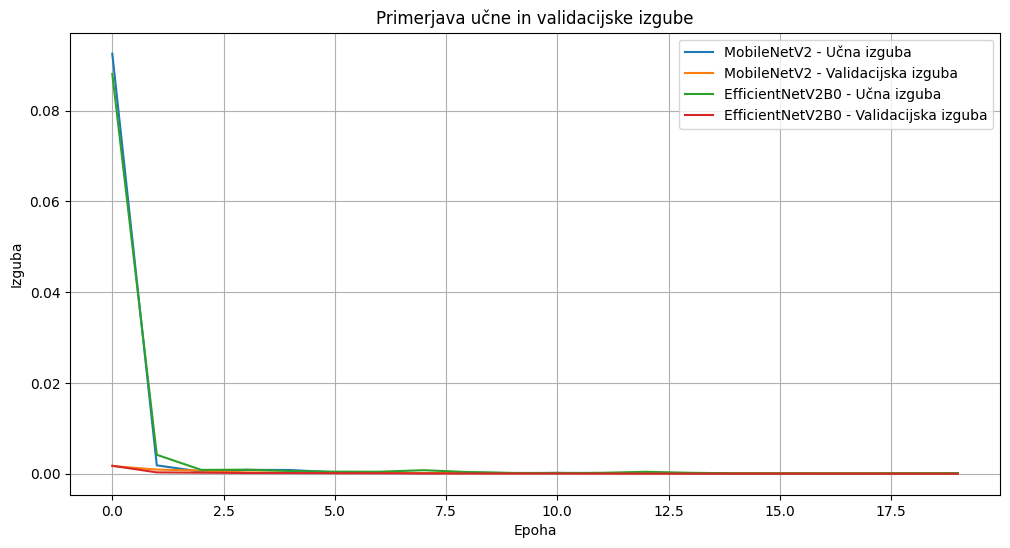

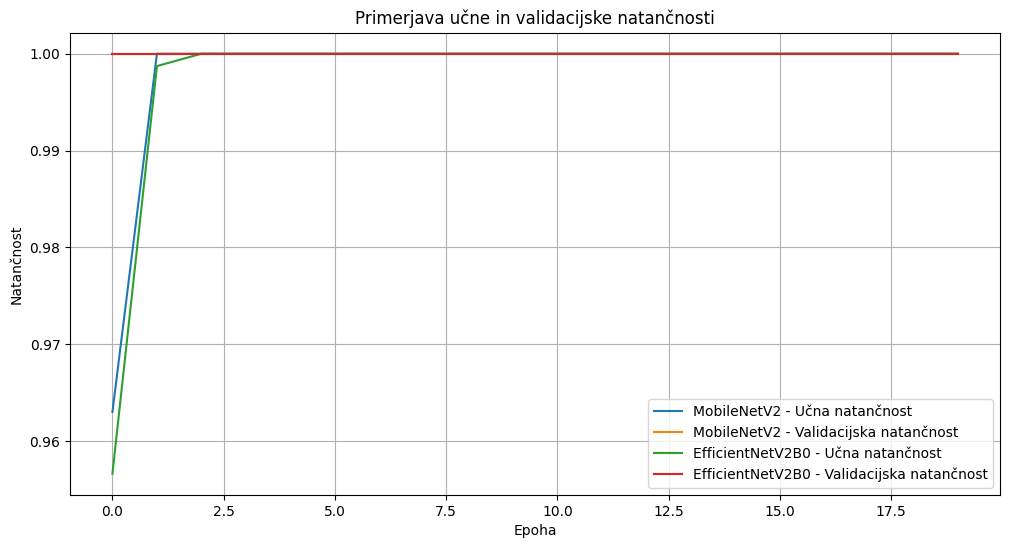


--- Povzetek končnih rezultatov na testni množici ---
           Model Testna izguba Testna natančnost
     MobileNetV2        0.0001            1.0000
EfficientNetV2B0        0.0001            1.0000


In [39]:
print("\n--- VIZUALIZACIJA REZULTATOV ---")

if history_mobilenet is not None and history_efficientnet is not None:
    # Graf izgube (Loss)
    plt.figure(figsize=(12, 6))
    plt.plot(history_mobilenet.history['loss'], label='MobileNetV2 - Učna izguba')
    plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV2 - Validacijska izguba')
    plt.plot(history_efficientnet.history['loss'], label='EfficientNetV2B0 - Učna izguba')
    plt.plot(history_efficientnet.history['val_loss'], label='EfficientNetV2B0 - Validacijska izguba')
    plt.title('Primerjava učne in validacijske izgube')
    plt.xlabel('Epoha')
    plt.ylabel('Izguba')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graf natančnosti (Accuracy)
    plt.figure(figsize=(12, 6))
    plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 - Učna natančnost')
    plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2 - Validacijska natančnost')
    plt.plot(history_efficientnet.history['accuracy'], label='EfficientNetV2B0 - Učna natančnost')
    plt.plot(history_efficientnet.history['val_accuracy'], label='EfficientNetV2B0 - Validacijska natančnost')
    plt.title('Primerjava učne in validacijske natančnosti')
    plt.xlabel('Epoha')
    plt.ylabel('Natančnost')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Tabela končnih rezultatov
    print("\n--- Povzetek končnih rezultatov na testni množici ---")
    results = pd.DataFrame({
        'Model': ['MobileNetV2', 'EfficientNetV2B0'],
        'Testna izguba': [f'{loss_mobilenet:.4f}' if loss_mobilenet is not None else 'N/A',
                         f'{loss_efficientnet:.4f}' if loss_efficientnet is not None else 'N/A'],
        'Testna natančnost': [f'{acc_mobilenet:.4f}' if acc_mobilenet is not None else 'N/A',
                             f'{acc_efficientnet:.4f}' if acc_efficientnet is not None else 'N/A']
    })
    print(results.to_string(index=False))

else:
    print("\nVizualizacija in povzetek nista mogoča, ker vsaj en model ni bil uspešno treniran.")
